# Comparação de resultados: LLM x Z3
Este notebook consolida os registros salvos e apresenta uma visão rápida dos resultados de cada modelo. Puzzles Knights and Knaves em comparação com a solução obtida via Z3.

## Como usar
1. Gere puzzles e execute `main_gemini.py` ou `main_gpt.py` para popular os arquivos `resultados/*.jsonl`.
2. Reabra ou reexecute este notebook para atualizar as métricas e gráficos.

In [1]:
import json
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-muted')
pd.options.display.max_colwidth = 120


In [2]:
def load_jsonl(path: str, model_label: str) -> pd.DataFrame:
    file_path = Path(path)
    if not file_path.exists():
        print(f"Aviso: arquivo {path} não encontrado.")
        return pd.DataFrame()

    rows = []
    with file_path.open(encoding='utf-8') as fp:
        for line in fp:
            line = line.strip()
            if not line:
                continue
            rows.append(json.loads(line))

    if not rows:
        print(f"Aviso: arquivo {path} está vazio.")
        return pd.DataFrame()

    df = pd.DataFrame(rows)
    if 'model' in df.columns:
        df['model_name'] = df['model']
    else:
        df['model_name'] = model_label

    df['match'] = df['match'].astype(bool)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df


In [3]:
gemini_df = load_jsonl('resultados/results.jsonl', 'gemini-2.5-flash')
gpt_df = load_jsonl('resultados/results_gpt.jsonl', 'gpt-4o-mini')

df = pd.concat([gemini_df, gpt_df], ignore_index=False)
df = df.sort_values('timestamp') if not df.empty else df
df.head()


,timestamp,puzzle_file,puzzle_text,llm_answer,z3_answer,match,model_name,model
0,2025-11-22 16:49:56.905591,puzzle1.txt,"Em uma ilha vivem apenas cavaleiros e patifes. \nCavaleiros sempre dizem a verdade, e patifes sempre mentem.\nA diz:...","Vamos resolver o problema em duas partes: primeiro, manualmente, e depois usando a biblioteca Z3.\n\n---\n\n### **Re...","{'A': False, 'B': True}",False,gemini-2.5-flash,NaN
0,2025-11-22 16:50:48.934576,puzzle1.txt,"Em uma ilha vivem apenas cavaleiros e patifes. \nCavaleiros sempre dizem a verdade, e patifes sempre mentem.\nA diz:...","Vamos resolver o problema de forma lógica primeiro:\n\n1. A diz: ""B é um patife.""\n2. B diz: ""A e eu somos diferente...","{'A': False, 'B': True}",False,gpt-4o-mini,gpt-4o-mini
1,2025-11-23 00:00:03.053237,puzzle2.txt,"Em uma ilha vivem apenas cavaleiros e patifes. \nCavaleiros sempre dizem a verdade, e patifes sempre mentem.\nA diz:...","Vamos resolver o problema com base nas declarações feitas por A, B e C.\n\n1. **Analisando as declarações:**\n - A...","{'A': False, 'B': True, 'C': True}",False,gpt-4o-mini,gpt-4o-mini
2,2025-11-23 00:01:04.292367,puzzle3.txt,"Em uma ilha vivem apenas cavaleiros e patifes.\nCavaleiros sempre dizem a verdade, e patifes sempre mentem.\nA diz: ...","Vamos resolver o problema passo a passo.\n\n1. **Análise das declarações:**\n - A diz: ""B e eu somos diferentes.""\...","{'A': True, 'B': False, 'C': False}",False,gpt-4o-mini,gpt-4o-mini
3,2025-11-23 00:02:26.732062,puzzle4.txt,"Em uma ilha vivem apenas cavaleiros e patifes.\nCavaleiros sempre dizem a verdade, e patifes sempre mentem.\nA diz: ...","Vamos resolver o problema usando lógica e, em seguida, traduzir para o Z3 para uma representação formal.\n\n**Anális...","{'A': False, 'B': True, 'C': None}",False,gpt-4o-mini,gpt-4o-mini


## Visão geral por modelo

In [4]:
if df.empty:
    print('Sem dados disponíveis. Execute os scripts principais antes de rodar este notebook.')
else:
    resumo = (
        df.groupby('model_name')['match']
        .agg(total='count', acertos='sum')
        .assign(taxa_acerto=lambda x: (x['acertos'] / x['total'] * 100).round(1))
        .sort_values('taxa_acerto', ascending=False)
    )
    display(resumo)


,total,acertos,taxa_acerto
model_name,,,
gemini-2.5-flash,12,0,0.0
gpt-4o-mini,10,0,0.0


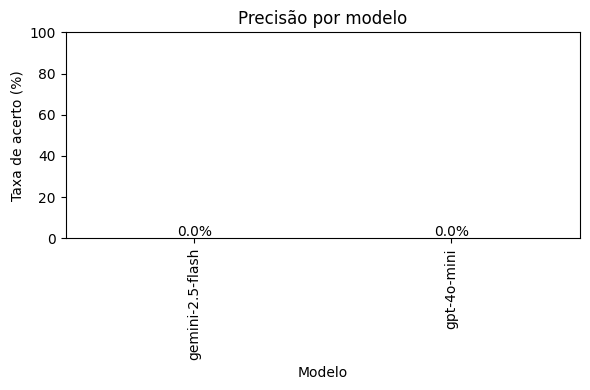

In [5]:
if not df.empty:
    fig, ax = plt.subplots(figsize=(6, 4))
    resumo.reset_index().plot(
        x='model_name', y='taxa_acerto', kind='bar', color='#4c72b0', legend=False, ax=ax
    )
    ax.set_ylabel('Taxa de acerto (%)')
    ax.set_xlabel('Modelo')
    ax.set_ylim(0, 100)
    ax.set_title('Precisão por modelo')
    for idx, value in enumerate(resumo['taxa_acerto']):
        ax.text(idx, value + 1, f"{value:.1f}%", ha='center')
    plt.tight_layout()
    plt.show()


## Desempenho por puzzle

In [6]:
if not df.empty:
    puzzle_summary = (
        df.groupby(['puzzle_file', 'model_name'])['match']
        .agg(total='count', acertos='sum')
        .assign(taxa_acerto=lambda x: (x['acertos'] / x['total'] * 100).round(1))
        .reset_index()
        .sort_values(['puzzle_file', 'model_name'])
    )
    display(puzzle_summary)


,puzzle_file,model_name,total,acertos,taxa_acerto
0,puzzle1.txt,gemini-2.5-flash,1,0,0.0
1,puzzle1.txt,gpt-4o-mini,1,0,0.0
2,puzzle10.txt,gemini-2.5-flash,1,0,0.0
3,puzzle10.txt,gpt-4o-mini,1,0,0.0
4,puzzle11.txt,gemini-2.5-flash,1,0,0.0
5,puzzle2.txt,gemini-2.5-flash,1,0,0.0
6,puzzle2.txt,gpt-4o-mini,1,0,0.0
7,puzzle3.txt,gemini-2.5-flash,1,0,0.0
8,puzzle3.txt,gpt-4o-mini,1,0,0.0
9,puzzle4.txt,gemini-2.5-flash,1,0,0.0


## Onde os modelos erraram

In [7]:
if not df.empty:
    erros = df[~df['match']]
    if erros.empty:
        print('Nenhum erro registrado até o momento.')
    else:
        display(
            erros[
                ['timestamp', 'model_name', 'puzzle_file', 'llm_answer', 'z3_answer']
            ].sort_values('timestamp')
        )


,timestamp,model_name,puzzle_file,llm_answer,z3_answer
0,2025-11-22 16:49:56.905591,gemini-2.5-flash,puzzle1.txt,"Vamos resolver o problema em duas partes: primeiro, manualmente, e depois usando a biblioteca Z3.\n\n---\n\n### **Re...","{'A': False, 'B': True}"
0,2025-11-22 16:50:48.934576,gpt-4o-mini,puzzle1.txt,"Vamos resolver o problema de forma lógica primeiro:\n\n1. A diz: ""B é um patife.""\n2. B diz: ""A e eu somos diferente...","{'A': False, 'B': True}"
1,2025-11-23 00:00:03.053237,gpt-4o-mini,puzzle2.txt,"Vamos resolver o problema com base nas declarações feitas por A, B e C.\n\n1. **Analisando as declarações:**\n - A...","{'A': False, 'B': True, 'C': True}"
2,2025-11-23 00:01:04.292367,gpt-4o-mini,puzzle3.txt,"Vamos resolver o problema passo a passo.\n\n1. **Análise das declarações:**\n - A diz: ""B e eu somos diferentes.""\...","{'A': True, 'B': False, 'C': False}"
3,2025-11-23 00:02:26.732062,gpt-4o-mini,puzzle4.txt,"Vamos resolver o problema usando lógica e, em seguida, traduzir para o Z3 para uma representação formal.\n\n**Anális...","{'A': False, 'B': True, 'C': None}"
4,2025-11-23 00:03:00.813456,gpt-4o-mini,puzzle5.txt,"Para resolver o problema e determinar quem em A, B e C é um cavaleiro e quem é um patife, precisamos analisar as dec...","{'A': False, 'B': None, 'C': True}"
5,2025-11-23 00:03:25.301210,gpt-4o-mini,puzzle6.txt,"Para resolver esse problema, vamos analisar as declarações feitas pelos personagens A, B e C.\n\n1. A diz: ""B é um p...","{'A': True, 'B': False, 'C': False}"
6,2025-11-23 00:04:09.758320,gpt-4o-mini,puzzle7.txt,"Para resolver o problema, vamos analisar as afirmações dos três personagens, A, B e C.\n\n1. A diz: ""C e B são iguai...","{'A': False, 'B': True, 'C': True}"
7,2025-11-23 00:04:38.110294,gpt-4o-mini,puzzle8.txt,Vamos analisar as declarações para tentar determinar quem são os cavaleiros e quem são os patifes:\n\n1. **A diz**: ...,"{'A': True, 'B': None, 'C': False}"
8,2025-11-23 00:05:30.802952,gpt-4o-mini,puzzle9.txt,"Vamos resolver o problema de lógica primeiro.\n\nTemos três pessoas: A, B e C. Vamos analisar as afirmações:\n\n1. A...","{'A': True, 'B': True, 'C': False}"
